**Financial Econometrics Module Exercises**

In [56]:
import time
import numpy as np
import pandas as pd
import yfinance as yf
import statsmodels.api as sm
import itertools
import matplotlib.pyplot as plt
from statsmodels.tsa.stattools import adfuller, kpss


**Problem 1**

Simulation of omitted variable bias and compare estimates with and without the omitted predictor.

In [39]:
def ols(y, X):
    """OLS via least squares. X should include intercept column if desired."""
    beta = np.linalg.lstsq(X, y, rcond=None)[0]
    return beta

np.random.seed(0)
a = 1.0   # intercept
b = 2.0   # coefficient on X (true)
c = 3.0   # coefficient on Z (true, omitted in reduced model)
sigma = 1.0
rho = 0.6  # correlation between X and Z (Cov(X,Z) = rho if Var(X)=1)

ns = [100, 1000, 10000]  # sample sizes to test
reps = 400               # Monte Carlo reps per sample size

results = []

for n in ns:
    b_full = np.zeros(reps)
    c_full = np.zeros(reps)
    b_red = np.zeros(reps)
    for r in range(reps):
        
        # generate correlated X and Z
        X = np.random.normal(size=n)
        U = np.random.normal(size=n)
        Z = rho * X + np.sqrt(1 - rho**2) * U  # Var(Z) ≈ 1, Cov(X,Z) ≈ rho
        
        # noise independent of X, Z
        e = np.random.normal(scale=sigma, size=n)
        y = a + b * X + c * Z + e
        
        # full model (intercept, X, Z)
        X_full = np.column_stack((np.ones(n), X, Z))
        beta_full = ols(y, X_full)
        b_full[r] = beta_full[1]
        c_full[r] = beta_full[2]
        
        # reduced model (intercept, X) - Z omitted
        X_red = np.column_stack((np.ones(n), X))
        beta_red = ols(y, X_red)
        b_red[r] = beta_red[1]
    
    results.append({
        'n': n,
        'true_b': b,
        'true_c': c,
        'mean_b_full': b_full.mean(),
        'sd_b_full': b_full.std(ddof=1),
        'mean_c_full': c_full.mean(),
        'sd_c_full': c_full.std(ddof=1),
        'mean_b_reduced': b_red.mean(),
        'sd_b_reduced': b_red.std(ddof=1),
        'mean_bias_reduced': b_red.mean() - b,
        'theoretical_bias': c * rho
    })

df = pd.DataFrame(results)
df

,n,true_b,true_c,mean_b_full,sd_b_full,mean_c_full,sd_c_full,mean_b_reduced,sd_b_reduced,mean_bias_reduced,theoretical_bias
0,100,2.0,3.0,2.000558,0.124435,2.999465,0.123822,3.806932,0.268234,1.806932,1.8
1,1000,2.0,3.0,1.999922,0.040389,2.999588,0.040053,3.799320,0.081780,1.799320,1.8
2,10000,2.0,3.0,1.999752,0.013286,2.999612,0.012629,3.799776,0.025355,1.799776,1.8


**Inference**

- The full-model estimates for b and c are approximately unbiased and converge to the true values (mean_b_full ≈ 2.0, mean_c_full ≈ 3.0) and their standard deviations shrink as n increases using simulation n ∈ {100, 1000, 10000}.
- The reduced-model estimate for b is shifted upward by about the theoretical bias (mean_b_reduced ≈ 3.80 in the simulations), matching the predicted b + Cρ = 3.8. where, Cρ = theorectical bias.
- Increasing sample size does not remove the bias. What changes with larger n is variance: the estimates become more tightly concentrated around their (biased) limits. So, the reduced estimator converges to a wrong value (consistent for the wrong parameter) and the omitted-variable bias is asymptotic and does not vanish by increasing n.


**Problem 2**

Using the Even Group number: FE-GWP1_model_selection_2.csv

In [48]:
colnames = ["Y", "Z1", "Z2", "Z3", "Z4", "Z5"]
df = pd.read_csv("FE-GWP1_model_selection_2.csv", names=colnames, header=0)
df.head()

,Y,Z1,Z2,Z3,Z4,Z5
0,2.172296,0.121634,-0.051562,0.570616,1.279931,0.075233
1,0.502380,0.025446,-0.093062,0.304875,-0.582292,0.377388
2,0.711362,-0.136716,-0.082229,-0.191680,-0.647970,1.230986
3,-0.557168,-0.284459,-0.170922,-0.853670,-1.256146,-0.991686
4,1.500199,0.105205,-0.169141,0.826558,0.640945,1.099873


In [50]:
# Dependent and independent variables
Y = df['Y']
X = df[['Z1', 'Z2', 'Z3', 'Z4', 'Z5']]

In [51]:
# Function to fit OLS and return Adjusted R2, AIC, and BIC
def fit_model(X, y):
    X = sm.add_constant(X)  # add intercept
    model = sm.OLS(y, X).fit()
    return model

In [61]:
# Exhaustive Search - trying all possible subsets of predictors
results = []
predictors = ['Z1','Z2','Z3','Z4','Z5']

for k in range(1, len(predictors)+1):
    for subset in itertools.combinations(predictors, k):
        X_subset = df[list(subset)]
        model = fit_model(X_subset, Y)
        results.append({
            'variables': subset,
            'adj_r2': model.rsquared_adj,
            'aic': model.aic,
            'bic': model.bic
        })

results_df = pd.DataFrame(results)
results_adj_r2 = results_df.sort_values(by="adj_r2", ascending=False).head()

In [64]:
results_adj_r2.to_csv("model_selection_results_r2.csv", index=False)
results_df.to_csv("model_selection_results.csv", index=False)

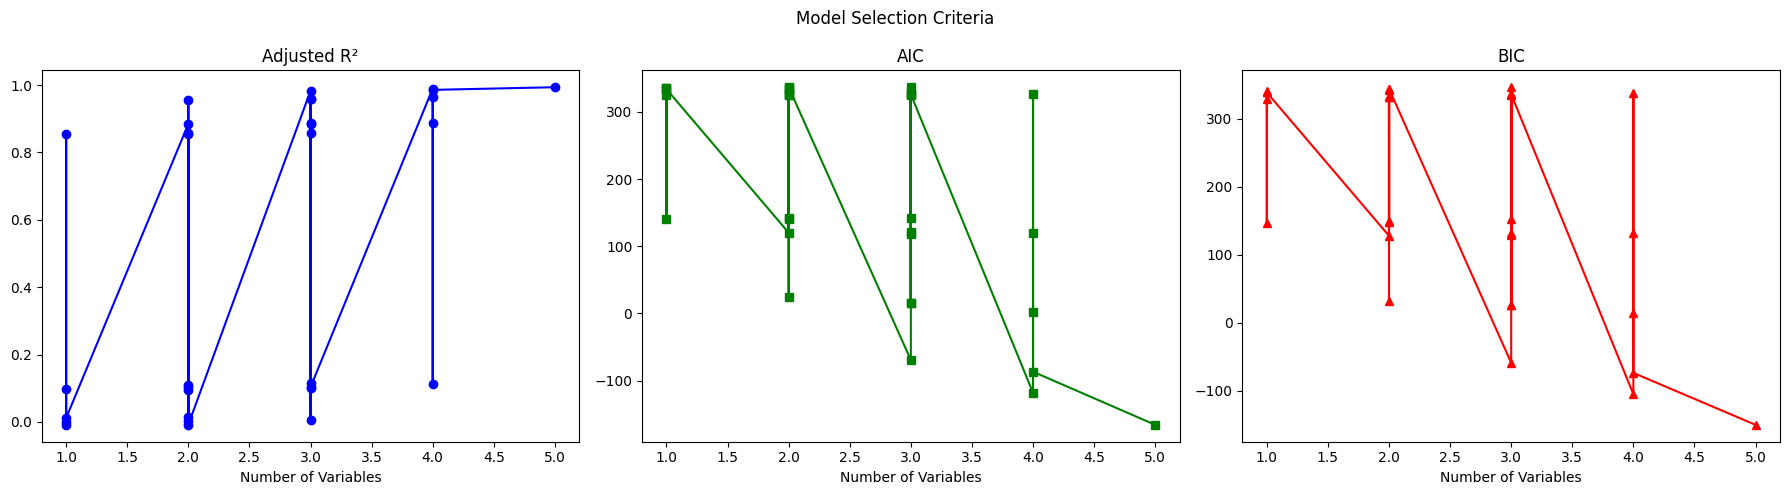

In [58]:
fig, axes = plt.subplots(1, 3, figsize=(18,5))

# Adjusted R2
axes[0].plot(results_df['num_vars'], results_df['adj_r2'], marker='o', color='blue')
axes[0].set_title('Adjusted R²')
axes[0].set_xlabel('Number of Variables')

# AIC
axes[1].plot(results_df['num_vars'], results_df['aic'], marker='s', color='green')
axes[1].set_title('AIC')
axes[1].set_xlabel('Number of Variables')

# BIC
axes[2].plot(results_df['num_vars'], results_df['bic'], marker='^', color='red')
axes[2].set_title('BIC')
axes[2].set_xlabel('Number of Variables')

plt.suptitle("Model Selection Criteria")
plt.tight_layout()
plt.show()

**Inferences**

We estimated all possible subsets of predictors Z1, Z2, Z3, Z4, Z5 and compared models using Adjusted R Squared, AIC, and BIC.

- **Adjusted R Squared**
	The chart (left panel) shows Adjusted R squared increases as more variables are included.
	The highest Adjusted R squared = 0.9936 is achieved by the full model (Z1–Z5).
	This means the full model explains about 99% of the variation in Y, even after adjusting for the number of regressors.

- **AIC (Akaike Information Criterion)**
	AIC decreases as more predictors are added, reaching the lowest value = -165.90 at the full model (Z1–Z5).
	Since smaller AIC indicates a better trade-off between fit and complexity, AIC favors the full model.

- **BIC (Bayesian Information Criterion)**
	BIC also selects the full model (Z1–Z5), with the lowest BIC = -150.27.
	Unlike AIC, BIC penalizes complexity more strongly, but still finds the full model preferable, suggesting that all five predictors contribute valuable information.

The three approaches (Adjusted R Squared, AIC, BIC) select the full model:

Y ~Z1 + Z2 + Z3 + Z4 + Z5

This means each regressor contributes useful explanatory power. Dropping any variable worsens model performance even after adjusting for complexity. Therefore, the optimal regression specification is the five-variable model.


**Problem 3**
- Use real economic data for equities and illustrate if the time series you chose has a unit root.
- The Python code illustrates how to implement the Augmented Dickey–Fuller (ADF) and KPSS tests on equity data. The example employs the SPY

In [23]:
from alpha_vantage.timeseries import TimeSeries
import pandas as pd

api_key = "CIGCA4Z6GK5BXTD2"
ts = TimeSeries(key=api_key, output_format="pandas")

px, _ = ts.get_daily(symbol="SPY", outputsize="full")

# Fix index: convert to datetime and sort
px.index = pd.to_datetime(px.index)
px = px.sort_index()

# Now you can slice safely
px = px["4. close"].loc["2015-01-01":]

print(px.head())
print(px.tail())

date
2015-01-02    205.43
2015-01-05    201.72
2015-01-06    199.82
2015-01-07    202.31
2015-01-08    205.90
Name: 4. close, dtype: float64
date
2025-09-08    648.83
2025-09-09    650.33
2025-09-10    652.21
2025-09-11    657.63
2025-09-12    657.41
Name: 4. close, dtype: float64


In [25]:
# 2) Build log-levels and log-returns
logp = np.log(px)
ret = logp.diff().dropna()

def adf_kpss(series, name):
    # ADF (H0: unit root)
    adf_stat, adf_p, *_ = adfuller(series, maxlag=None, regression='c', autolag='AIC')
    # KPSS (H0: stationarity)
    kpss_stat, kpss_p, *_ = kpss(series, regression='c', nlags="auto")
    print(f"\n{name}:")
    print(f"  ADF:  stat={adf_stat: .3f}, p={adf_p: .3f}  (H0=unit root)")
    print(f"  KPSS: stat={kpss_stat: .3f}, p={kpss_p: .3f} (H0=stationary)")

adf_kpss(logp.dropna(), "Log Price")
adf_kpss(ret.dropna(), "Log Return")


/var/folders/gh/l_8ybplj4t7c9q_9dy0sphcc0000gp/T/ipykernel_31148/1994020445.py:9: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is smaller than the p-value returned.

  kpss_stat, kpss_p, *_ = kpss(series, regression='c', nlags="auto")



Log Price:
  ADF:  stat=-0.249, p= 0.932  (H0=unit root)
  KPSS: stat= 8.132, p= 0.010 (H0=stationary)

Log Return:
  ADF:  stat=-16.632, p= 0.000  (H0=unit root)
  KPSS: stat= 0.059, p= 0.100 (H0=stationary)


/var/folders/gh/l_8ybplj4t7c9q_9dy0sphcc0000gp/T/ipykernel_31148/1994020445.py:9: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is greater than the p-value returned.

  kpss_stat, kpss_p, *_ = kpss(series, regression='c', nlags="auto")


The empirical results indicate that the log price series fails to reject the unit root hypothesis, while the log return series rejects the unit root and satisfies the stationarity assumption. This finding is consistent with the well-established property in financial econometrics that asset prices are integrated of order one, I(1), whereas returns are stationary, I(0)

**Problem 4**

A simulation exercise clarifies the difference between the two cases. When ρ = 1, the process follows a random walk with variance that increases linearly over time. When ρ > 1, the process becomes explosive, with variance increasing geometrically. The latter is rarely consistent with observed macroeconomic or financial data, which explains the focus on detecting unit roots (ρ = 1) rather than explosive roots.

In [26]:
def ar1(rho=1.0, n=500, sigma=1.0, seed=0):
    rng = np.random.default_rng(seed)
    u = rng.normal(0, sigma, size=n)
    y = np.zeros(n)
    for t in range(1, n):
        y[t] = rho*y[t-1] + u[t]
    return y

y_unit = ar1(rho=1.0)   # random walk: variance ~ linear in t
y_expl = ar1(rho=1.5)   # explosive: variance grows ~ geometrically



In [27]:
# Compare empirical standard deviations over time windows
df = pd.DataFrame({"unit_root": y_unit, "explosive": y_expl})
print(df.std())


unit_root    8.588120e+00
explosive    1.077383e+86
dtype: float64


**Economic intuition.**
- Unit root (ρ=1): series is highly persistent but plausible in macro/finance (e.g., asset prices); shocks have permanent effects; variance grows linearly → inference on levels is invalid; difference the data or use cointegration.
- Explosive (ρ=1.5): values blow up exponentially; this is rarely a reasonable data-generating process for real economies (budget constraints, arbitrage, and institutional limits prevent explosive paths). That’s why empiricists emphasize detecting ρ=1, not >1.


**Problem 5**

How would you test this possibility using a single regression and a suitable dummy variable (a dummy variable is a variable that only takes the values 0 and 1

In [33]:
# Example data (replace Y, X with actual values)
t = np.arange(1, 21)
X = np.random.randn(20)
Y = 2 + 0.5*X + np.where(t>=11, 1.0*X, 0) + np.random.randn(20)  # sample with slope change

D = (t >= 11).astype(int)
Xint = D * X

Xmat = sm.add_constant(pd.DataFrame({"X": X, "D": D, "DX": Xint}))
model = sm.OLS(Y, Xmat).fit()
print(model.summary())


                            OLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.654
Model:                            OLS   Adj. R-squared:                  0.589
Method:                 Least Squares   F-statistic:                     10.06
Date:                Sat, 13 Sep 2025   Prob (F-statistic):           0.000575
Time:                        09:54:00   Log-Likelihood:                -31.077
No. Observations:                  20   AIC:                             70.15
Df Residuals:                      16   BIC:                             74.14
Df Model:                           3                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          1.3582      0.408      3.328      0.0

In [34]:
# Tests
print(model.f_test("D = 0, DX = 0"))   # joint: no break
print(model.t_test("DX = 0"))          # slope-only stability


<F test: F=1.9022359294180171, p=0.1814904341031912, df_denom=16, df_num=2>
                             Test for Constraints                             
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
c0             1.0786      0.939      1.149      0.268      -0.912       3.069


**Inference**

After estimating the regression, the pre-break slope is β̂ = 0.5773, and the post-break slope is β̂ + θ̂  = 1.656. The joint F-test for the significance of D and D.X yields F = 1.902 with p = 0.181, indicating failure to reject the null hypothesis of parameter stability at t = 10. Therefore, there is no statistical evidence of a structural break, although the post-break slope is numerically larger. Residual diagnostics suggest the model assumptions are reasonably satisfied.